# Exploratory Data Analysis

In this notebook, I will dive into the dataset and find out what information I can get from it to better understand what we can learn with it. I will also check a word cloud to find out if it's possible to get insights from the negative and positive reviews.

Since, it's the hotel with the highest number of reviews, I will be analyzing the hotel Britannia International Hotel Canary Wharf in London.

# Importing Libraries and Datasets

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

# Import libraries for NLP
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction import text 

# Solve warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Importing Dataset

In [2]:
df = pd.read_csv('../csv/Hotel_Reviews.csv')

In [3]:
# Checking Dataframe
df.head(1)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738 non-null flo

In [5]:
df.shape

(515738, 17)

In [6]:
# Checking the hotel with the highest number of reviews
df.pivot_table(index=['Hotel_Name'], aggfunc='size').nlargest()

Hotel_Name
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
dtype: int64

As we can see, Britannia International Hotel Canary Wharf have the highest number of reviews. I will use it for the word cloud.

It seems like `Reviewer_Score` is my best candidate for my target. Let's understand it a little bit more.

In [7]:
print(df['Reviewer_Score'].nlargest(1))
print(df['Reviewer_Score'].nsmallest(1))

7    10.0
Name: Reviewer_Score, dtype: float64
146    2.5
Name: Reviewer_Score, dtype: float64


### Takeaways:
- The dataset has columns with objects and numbers
- The dataset has over 515K observations and 17 features
- The hotel with mode reviews is the Britannia International Hotel Canary Wharf in London

2.5 is the lowest score. Since we have over 515K observations, it's impossible that none reviewer gave a 0 score. This makes me believe that the final scores are given by Booking.com, not the reviewer. I will use a binary classification for my final problem.

Since the reviewers only had scores between 2.5 and 10, I will use anything below 7 as negative review and 7 and above as positive reviews. The other reason is that hotels consider scores between 5 and 6.9 as neutral. A guest that had a neutral experience might not come back to the hotel. They need to have a good experence. Thus, I'll include anything below 7 as negative.

## Create a DataFrame for the Word Cloud

Here I will create a new DataFrame only with the Britannia International Hotel Canary Wharf hotel.

In [8]:
# Creating dataframe with the hotel that I will analyze
hotel = df[df['Hotel_Name']=='Britannia International Hotel Canary Wharf']

In [9]:
# Checking Dataframe
hotel.head(2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
63942,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,31,9086,The location was excellent for getting to the O2,10,3,7.9,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.50191,-0.023221
63943,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,34,9086,The house keeping lady made my boyfriends day...,14,3,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0 days,51.50191,-0.023221


In [10]:
# Turning the score into a binary classification
hotel['Score'] = hotel['Reviewer_Score'].apply(lambda x: 0 if x < 7 else 1)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
hotel.shape

(4789, 18)

In [12]:
hotel.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'Score'],
      dtype='object')

### Takeaways:
- I created a new DataFrame for the hotel Britannia International Hotel Canary Wharf
- I turned the `Reviewer_Score` into a binary classification
    - Anything below 7 is negative and 7 and above is positive

# Word Cloud

We will create some word clouds to see if our data set makes sense and if our data cleaning words.

## Data Preparation

Let's first prepare the data for the word cloud

In [13]:
# Dropping all columns I will not need
hotel.drop(columns=['Hotel_Address', 'Additional_Number_of_Scoring',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',  
       'Tags', 'days_since_review', 'lat', 'lng'], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
# Checking DataFrame
hotel.head(2)

,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,Score
63942,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,The location was excellent for getting to the O2,7.9,1
63943,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,The house keeping lady made my boyfriends day...,8.3,1


## Top Words

In [15]:
# Creating new dfs for each classification
df_positive = hotel[hotel['Score']==1]
df_negative = hotel[hotel['Score']==0]

In [16]:
# Pulling out the text data for cleaned tweets
data_positive = df_positive['Positive_Review']
data_negative = df_negative['Negative_Review']

In [17]:
# Stop words
stop_words = set(stopwords.words('english'))

# Words that don't bring much sense to a word cloud
add_stop_words = ['t','great','good','nice','lovely','canary','hotel','wharf','rooms','really','stay',
                  'positive','money','poor','like','would','one','did','beds','s','didn','free','windows',
                  'tired','check','excellent','value','air','need','just','sleep','work','close','time','pay',
                   'needs','night','told','2','day','double','4', 'london']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Function to tokenize tweets and remove stop words with NLTK built-in library
def process_text(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [18]:
# Creating lists for processed hate & not hate data
process_positive = list(map(process_text, data_positive))
process_negative = list(map(process_text, data_negative))

In [19]:
# Exact amount of positive review
total_positive_review = set()
for comment in process_positive:
    total_positive_review.update(comment)
len(total_positive_review)

2146

In [20]:
# exact amount of positive review
total_negative_review = set()
for comment in process_negative:
    total_negative_review.update(comment)
len(total_negative_review)

5082

### Takeaways

- There 2,147 positive reviews and 5,083 negative reviews

## Most Common Words in Each Category

Let's see which are the most common words of each category

In [21]:
# Create list with all the words
flat_positive = [item for sublist in process_positive for item in sublist]
flat_negative = [item for sublist in process_negative for item in sublist]

In [22]:
# Use FreqDist to see the most common words
positive_freq = FreqDist(flat_positive)
negative_freq = FreqDist(flat_negative)

In [23]:
# Top 20 Words in the positive reviews
positive_freq.most_common(20)

[('room', 859),
 ('location', 700),
 ('staff', 586),
 ('clean', 316),
 ('friendly', 254),
 ('comfortable', 215),
 ('view', 208),
 ('helpful', 181),
 ('bed', 173),
 ('breakfast', 164),
 ('price', 153),
 ('upgraded', 111),
 ('service', 100),
 ('window', 95),
 ('facilities', 94),
 ('comfy', 93),
 ('food', 91),
 ('spacious', 90),
 ('tube', 89),
 ('amazing', 85)]

In [24]:
# Top 20 Words in the negative review
negative_freq.most_common(20)

[('room', 1475),
 ('staff', 565),
 ('breakfast', 386),
 ('bed', 369),
 ('old', 285),
 ('wifi', 240),
 ('window', 201),
 ('dirty', 196),
 ('service', 191),
 ('bathroom', 184),
 ('dated', 181),
 ('reception', 180),
 ('uncomfortable', 154),
 ('hot', 147),
 ('rude', 146),
 ('cold', 141),
 ('shower', 140),
 ('noisy', 138),
 ('pool', 127),
 ('food', 126)]

### Takeaways:
Please read the takeaways at the end of the section 3.4

## Visualizing these words

In [25]:
# Choosing the top 20 most common words
positive_bar_counts = [x[1] for x in positive_freq.most_common(20)]
positive_bar_words = [x[0] for x in positive_freq.most_common(20)]

# create counts of hate and not hate with values and words
negative_bar_counts = [x[1] for x in negative_freq.most_common(20)]
negative_bar_words = [x[0] for x in negative_freq.most_common(20)]

In [81]:
# set the color of the bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))
color2 = cm.magma(np.linspace(.4,.8, 30))

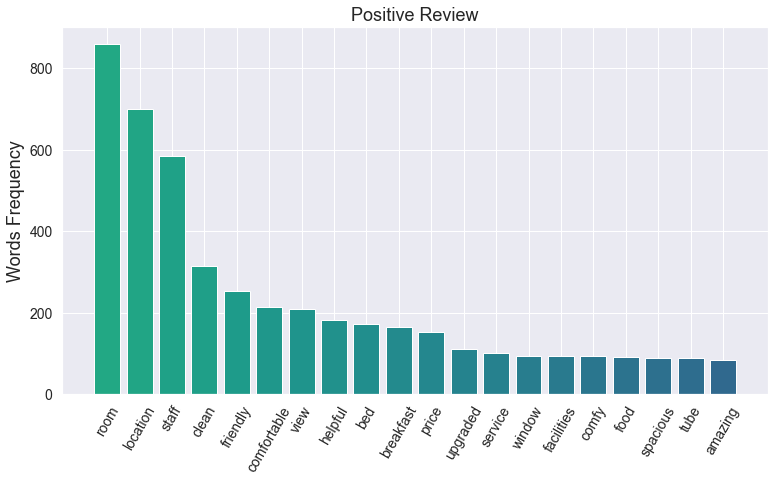

In [27]:
# Plotting the top 20 words in the positive reviews
new_figure = plt.figure(figsize=(20,6))
ax2 = new_figure.add_subplot(122)
ax2.bar(positive_bar_words, positive_bar_counts, color=color )

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.tight_layout(pad=0)
plt.title('Positive Review',fontsize=18)
plt.ylabel('Words Frequency',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../images/positive_freq.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

Seems like room, location, staff, clean, and friendly are the most popular words. The managemente can use these words and investigate where the hotel is doing a good job.

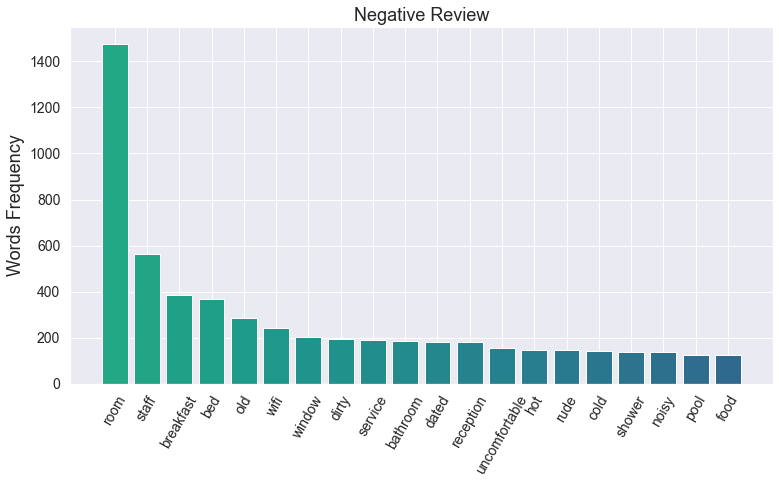

In [28]:
# Plotting the top 20 words in the negative reviews
new_figure = plt.figure(figsize=(20,6))
ax2 = new_figure.add_subplot(122)
ax2.bar(negative_bar_words, negative_bar_counts, color=color)

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.tight_layout(pad=0)
plt.title('Negative Review',fontsize=18)
plt.ylabel('Words Frequency',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../images/negative_freq.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

### Takeaways:

- We can see that all the words make sense and are related to hotels. This tells us that the stop words really worked
- From this lists, the hotel management can use to understand what guests who leave negative or positive reviews are talking about
- Seems like room, staff, breakfast, and the fact that the hotel might be old are the main reasons why users complain about a hotel. The management should investigate these points.
- We can see that the word 'room' appears more frequently in the Negative Reviews than in the Positive Reviews

## Word Cloud

In [29]:
# Create dictionaries
negative_dict = dict(zip(negative_bar_words, negative_bar_counts))
positive_dict = dict(zip(positive_bar_words, positive_bar_counts))

### Plotting Positive Reviews Word Cloud

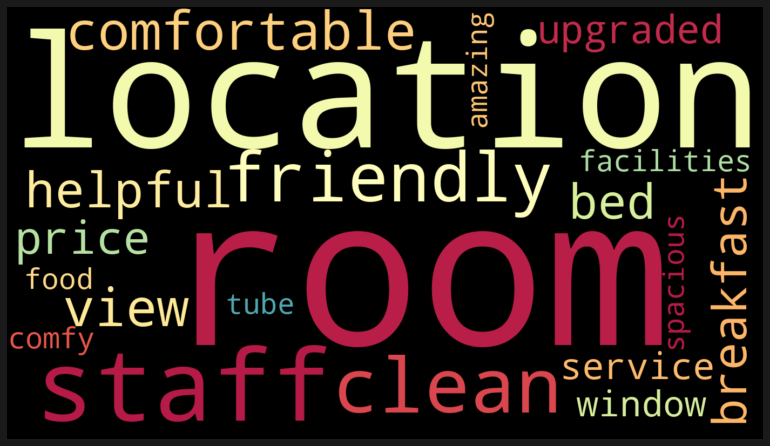

In [30]:
# create the word cloud:
wordcloud = WordCloud(background_color='black', width=1400, height=800, colormap='Spectral').generate_from_frequencies(positive_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(12,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('../images/positive_wordcloud.png', dpi=300)

plt.show()

In this image we can see the words that appear more often in the positive reviews. We can see that all the words make sense and are related to hotels. This tells us that the stop words really worked. From this lists, the hotel management can use to understand what guests who leave negative or positive reviews are talking about

### Plotting Negative Reviews Word Cloud

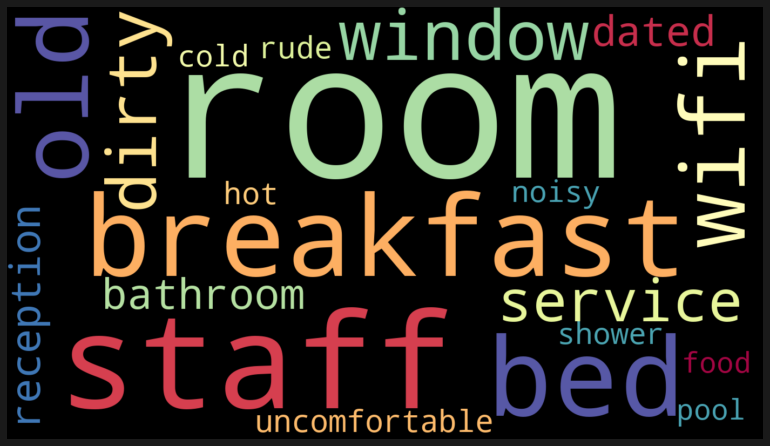

In [31]:
# create the word cloud:
wordcloud = WordCloud(background_color='black', width=1400, height=800, colormap='Spectral').generate_from_frequencies(negative_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(12,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('../images/negative_wordcloud.png', dpi=300)

plt.show()

In this image we can see the words that appear more often in the negative reviews. We can see that all the words make sense and are related to hotels. This tells us that the stop words really worked. From this lists, the hotel management can use to understand what guests who leave negative or positive reviews are talking about

# EDA

## Data Preparation

For the EDA, I will use a dataset with the city and country added to the original dataset. If you want to see the process to add the city and country, please check the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/geocoding.ipynb">Geopy</a> notebook.

In [32]:
# Importing DataFrame
df = pd.read_csv('../csv/hotel_review_city_state.csv')

In [33]:
# Checking how many countries there are hotels in the dataset
df.country.unique()

array(['España', 'Italia', 'Österreich', 'France', 'United Kingdom',
       'Nederland'], dtype=object)

The countries are written in their local language. I will fix that.

In [34]:
# Choosing features that I will be using
features = ['Hotel_Name','Review_Date', 'Average_Score',  'Reviewer_Nationality',
'Negative_Review', 'Positive_Review', 'Reviewer_Score','city', 'country']
df = df[features]

In [35]:
# Change countries' names to English
df['country'] = df['country'].apply(lambda x: 'Spain' if x == 'España' else 'Austria' if x == 'Österreich' else 'Netherlands' if x == 'Nederland' else x)

While plotting, I noticed that the name United States of America is way too long.

In [36]:
# Changing United States of America to USA
df['Reviewer_Nationality'] = df['Reviewer_Nationality'].apply(lambda x: 'USA' if x == ' United States of America ' else x)

In [37]:
# Checking DataFrame
df.head(2)

,Hotel_Name,Review_Date,Average_Score,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,city,country
0,Hotel Best Western PLUS Alfa Aeropuerto,8/2/2017,7.8,USA,The hotel wasn t close to the metro so we had...,Great price for what I got Rooms were extreme...,9.2,Barcelona,Spain
1,Hotel Best Western PLUS Alfa Aeropuerto,8/2/2017,7.8,Bangladesh,Far from the city,Restaurant was cozy Staffs were very friendly...,7.1,Barcelona,Spain


In [38]:
# Hotel DataFrame
hotel = df[df['Hotel_Name']=='Britannia International Hotel Canary Wharf']
london = df[df['city']== 'London']

hotel['Reviewer_Nationality'] = hotel['Reviewer_Nationality'].apply(lambda x: 'USA' if x == 'United States of America' else x)
london['Reviewer_Nationality'] = london['Reviewer_Nationality'].apply(lambda x: 'USA' if x == 'United States of America' else x)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Data Visualization

### Most common reviewer nationality

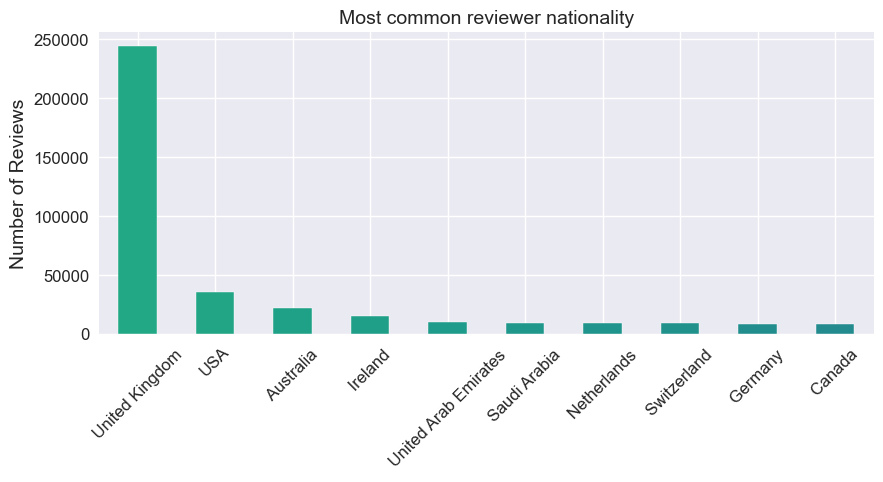

In [39]:
# Plotting reviewer nationality
plt.style.use('seaborn')
plt.figure(figsize=(10,4), dpi=100)
df['Reviewer_Nationality'].value_counts().nlargest(10).sort_values(ascending=False).plot(kind='bar', color=color)
plt.xticks(rotation=45)
plt.title('Most common reviewer nationality',fontsize=14)
plt.ylabel('Number of Reviews',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../images/nationality.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

It seems like reviewers from the UK are the reviewers that write the most reviews. Let's see what countries are the hotels with the most reviews.

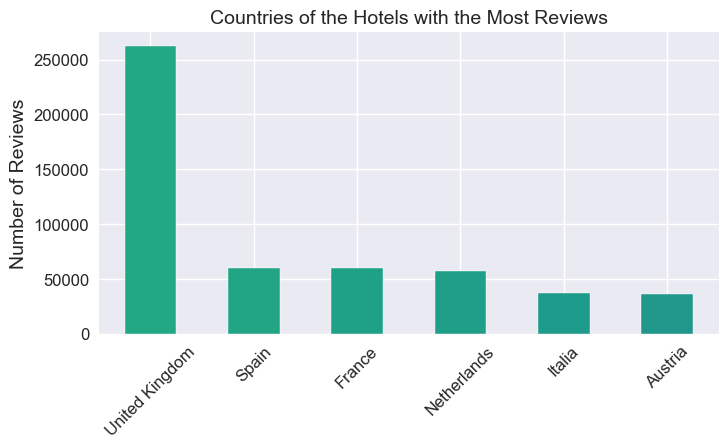

In [40]:
# Plotting countries where the hotels are
plt.style.use('seaborn')
plt.figure(figsize=(8,4), dpi=100)
df['country'].value_counts().sort_values(ascending=False).plot(kind='bar', color=color)
plt.xticks(rotation=45)
plt.title('Countries of the Hotels with the Most Reviews',fontsize=14)
plt.ylabel('Number of Reviews',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../images/countries-hotels.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

We can see that most than half of the hotels are in the UK. Thus, makes sense why the highest amount of reviewers are from the UK

### Score Density

Let's see the score density in Europe, London, and the hotel. We will be able to understand how the hotel compares to the whole Europe and to the city where it is located.

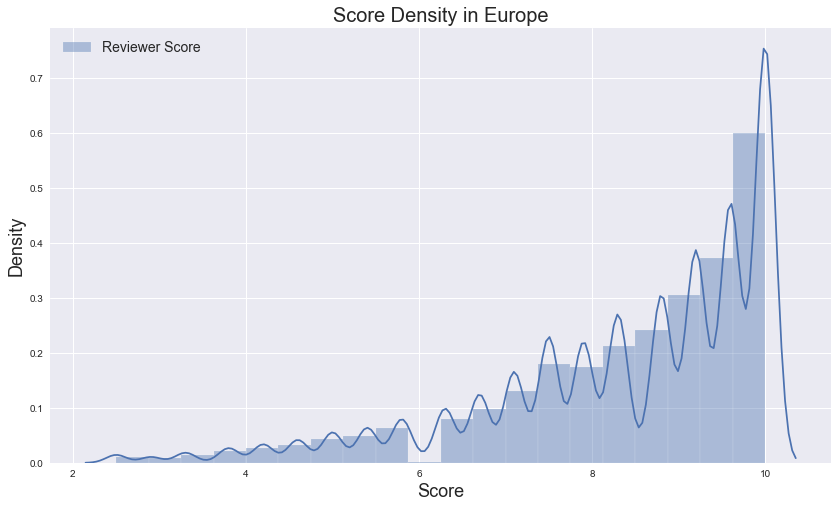

In [41]:
# Plotting score density in Europe
ax = plt.figure(figsize=(14,8))

# sns.distplot(df.Average_Score, label='Average Score')
sns.distplot(df.Reviewer_Score, label='Reviewer Score', bins= 20)
plt.legend(fontsize=14)
plt.title("Score Density in Europe", fontsize=20)
plt.xlabel('Score', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.savefig('../images/score-density-europe.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

Above we can the score density in Europe. We can see that the score us highly skewed to the right, meaning that most reviews are positive.

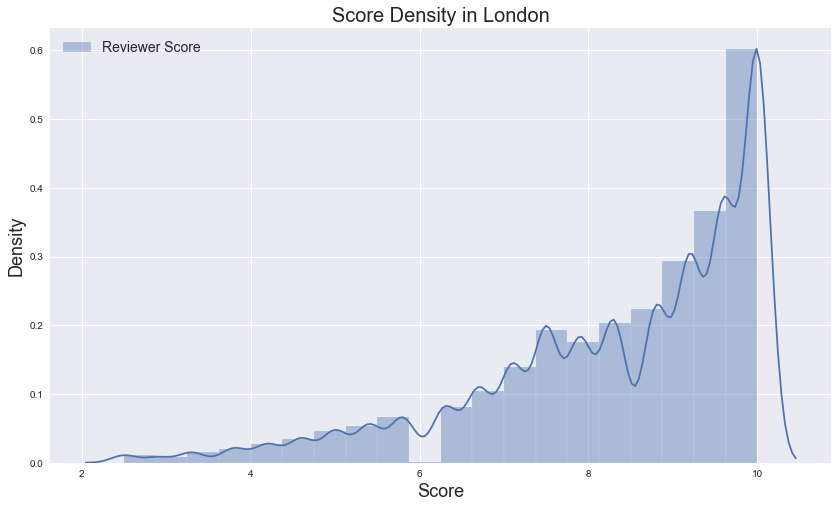

In [42]:
# Plotting score density in London
ax = plt.figure(figsize=(14,8))

sns.distplot(london.Reviewer_Score, label='Reviewer Score', bins=20)
plt.legend(fontsize=14)
plt.title("Score Density in London", fontsize=20)
plt.xlabel('Score', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.savefig('../images/score-density-london.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

Looking at the score density in London, we don't see much difference, only that the density in Europe is a little higher, which makes sense, since there are more reviews. There is also a weird gap near the number 6.

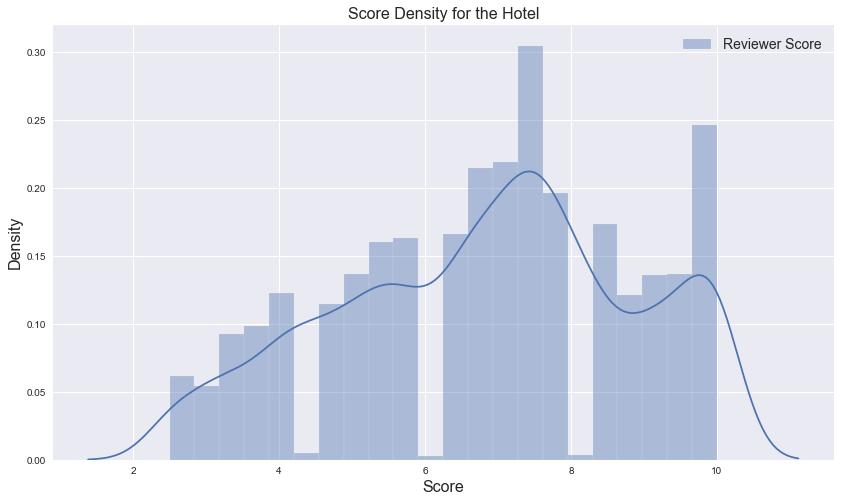

In [43]:
# Plotting the score density for the hotel
ax = plt.figure(figsize=(14,8))

sns.distplot(hotel.Reviewer_Score, label='Reviewer Score')
plt.legend(fontsize=14)
plt.title("Score Density for the Hotel", fontsize=16)
plt.xlabel('Score', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.savefig('../images/score-density-hotel.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

Looking at the hotel, we can see that the numbers are not skewed and there is a larges number of bad reviews with most reviews between 6 and 8.

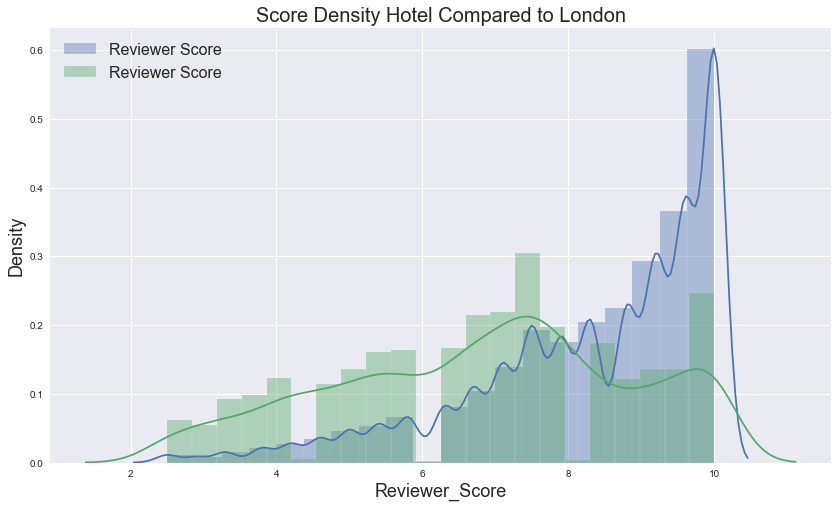

In [44]:
# Comparing the hotel score density to Europe
ax = plt.figure(figsize=(14,8))

# sns.distplot(df.Average_Score, label='Average Score')
sns.distplot(london.Reviewer_Score, label='Reviewer Score', bins=20)
plt.legend(fontsize=16)
plt.title("Score Density Hotel Compared to London", fontsize=20)
plt.xlabel('Score', fontsize=18)
plt.ylabel('Density', fontsize=18)
sns.distplot(hotel.Reviewer_Score, label='Reviewer Score')
plt.legend(fontsize=16)
plt.savefig('../images/score-density-hotel-vs-london.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

With this graph we can see that the hotel score density is worse than compared to London. While most reviews in London are positive, the hotel Britannia International Hotel Canary Wharf have a large amount of reviews categorized as bad

In [55]:
df['Reviewer_Score'].unique()

array([ 9.2,  7.1,  5.4,  6.3,  7.9,  7.5,  4.2,  6.7,  8.8,  2.5,  9.6,
        8.3,  3.3, 10. ,  4.6,  7. ,  5.8,  5. ,  3.5,  2.9,  3.8,  8.5,
        5.5,  6.5,  8. ,  6. ,  9. ,  9.4,  9.5,  4.5,  8.1,  3. ,  4. ,
        6.9,  4.4,  5.6,  3.1])

Looking at the scores, I don't see anything off that is causing the gap in the dataset.

### Compared average review to nationality (London and Hotel)

Let's compare the average hotel review given by nationality compared to the city of London

In [71]:
# Creating a plot to see the average of the reviews based on nationality of the reviewer
nationality = london.groupby(['Reviewer_Nationality']).describe()
nationality = nationality['Reviewer_Score']
nationality = nationality.nlargest(15, columns='count')
nationality.reset_index(inplace=True)

x = nationality['Reviewer_Nationality']
y = nationality['mean'].sort_values(ascending=False)

No handles with labels found to put in legend.


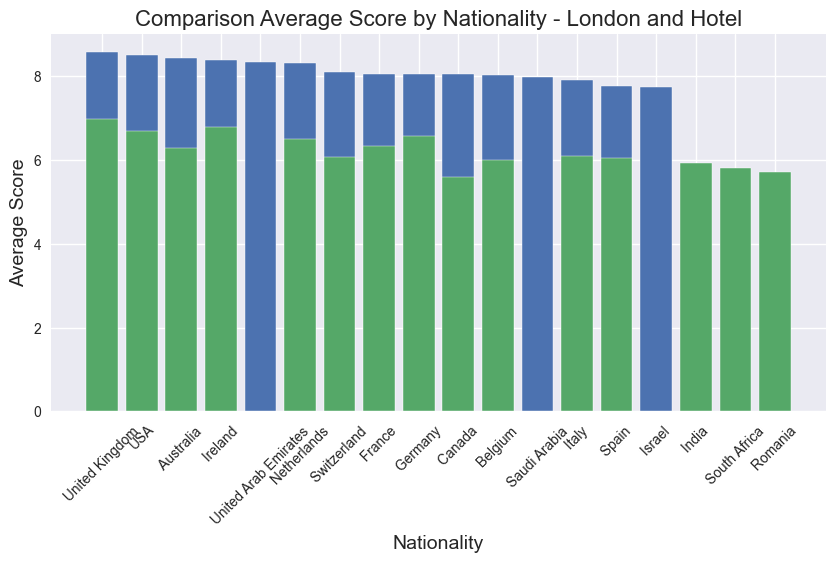

<Figure size 576x396 with 0 Axes>

In [121]:
plt.style.use('seaborn')
plt.figure(figsize=(10,5), dpi=100)
plt.bar(x, y)
plt.legend(fontsize=16)
plt.xlabel('Nationality', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation=45)
plt.title("Comparison Average Score by Nationality - London and Hotel", fontsize=16)
plt.savefig('filename.png', dpi=300)
plt.bar(x2, y2)
plt.show()

plt.savefig('../images/average-nationality.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

We can see that in almost